<a href="https://colab.research.google.com/github/ravichandranNa/AJ_ML_Library/blob/master/NLPABSTRACTAV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##PROBLEM STATEMENT:
Topic Modeling for Research Articles
Researchers have access to large online archives of scientific articles. As a consequence, finding relevant articles has become more difficult. Tagging or topic modelling provides a way to give token of identification to research articles which facilitates recommendation and search process.

Given the abstract and title for a set of research articles, predict the topics for each article included in the test set. 

Note that a research article can possibly have more than 1 topic. The research article abstracts and titles are sourced from the following 6 topics: 

1. Computer Science

2. Physics

3. Mathematics

4. Statistics

5. Quantitative Biology

6. Quantitative Finance

##Data Dictionary
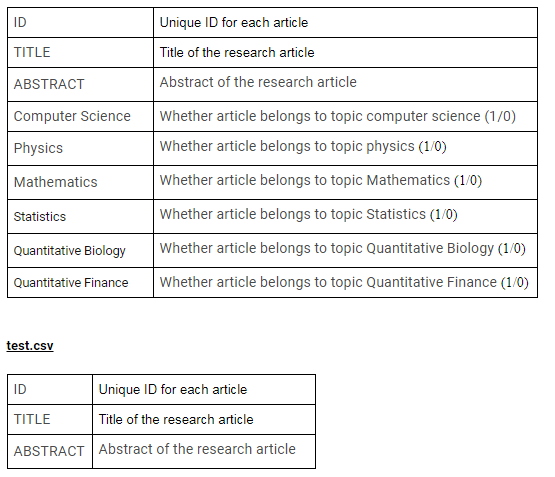

In [ ]:
import nltk
import matplotlib.pyplot as plt
import tweepy
from nltk.tokenize import word_tokenize
from nltk.text import Text
import numpy as np
import pandas as pd

import re
import spacy
import string
pd.options.mode.chained_assignment = None

from nltk.corpus import wordnet
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from collections import Counter
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm

import nltk
nltk.download('stopwords')

from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score


In [ ]:
train = pd.read_csv('/content/drive/My Drive/NLP/train.csv',    )
test = pd.read_csv('/content/drive/My Drive/NLP/test.csv')

In [ ]:
train.shape

(20972, 9)

In [ ]:
test.shape

(8989, 3)

In [ ]:
train.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [ ]:
test.head()

,ID,TITLE,ABSTRACT
0,20973,Closed-form Marginal Likelihood in Gamma-Poiss...,We present novel understandings of the Gamma...
1,20974,Laboratory mid-IR spectra of equilibrated and ...,Meteorites contain minerals from Solar Syste...
2,20975,Case For Static AMSDU Aggregation in WLANs,Frame aggregation is a mechanism by which mu...
3,20976,The $Gaia$-ESO Survey: the inner disk intermed...,Milky Way open clusters are very diverse in ...
4,20977,Witness-Functions versus Interpretation-Functi...,Proving that a cryptographic protocol is cor...


In [ ]:
train['total'] = train['Computer Science'] + train['Mathematics'] + train['Physics'] + train['Quantitative Biology'] + train['Quantitative Finance'] + train['Statistics']
train.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,total
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0,1
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0,1
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0,1
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0,1
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0,2


In [ ]:
more_than_one = train[train['total']>1]
more_than_one

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,total
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0,2
21,22,Many-Body Localization: Stability and Instability,Rare regions with weak disorder (Griffiths r...,0,1,1,0,0,0,2
28,29,Minimax Estimation of the $L_1$ Distance,We consider the problem of estimating the $L...,0,0,1,1,0,0,2
29,30,Density large deviations for multidimensional ...,We investigate the density large deviation f...,0,1,1,0,0,0,2
30,31,mixup: Beyond Empirical Risk Minimization,"Large deep neural networks are powerful, but...",1,0,0,1,0,0,2
...,...,...,...,...,...,...,...,...,...,...
20963,20964,Faithful Inversion of Generative Models for Ef...,Inference amortization methods share informa...,1,0,0,1,0,0,2
20964,20965,A social Network Analysis of the Operations Re...,We study the U.S. Operations Research/Indust...,1,0,0,1,0,0,2
20967,20968,Contemporary machine learning: a guide for pra...,Machine learning is finding increasingly bro...,1,1,0,0,0,0,2
20970,20971,On the Efficient Simulation of the Left-Tail o...,The sum of Log-normal variates is encountere...,0,0,1,1,0,0,2


##There are 5044 data points which covers more than one subject

In [ ]:
#Creating new data set on the basis of Computer Science
comp_sci = train[['TITLE','ABSTRACT','Computer Science']].copy()
comp_sci

,TITLE,ABSTRACT,Computer Science
0,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1
1,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1
2,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0
3,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0
4,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1
...,...,...,...
20967,Contemporary machine learning: a guide for pra...,Machine learning is finding increasingly bro...,1
20968,Uniform diamond coatings on WC-Co hard alloy c...,Polycrystalline diamond coatings have been g...,0
20969,Analysing Soccer Games with Clustering and Con...,We present a new approach for identifying si...,1
20970,On the Efficient Simulation of the Left-Tail o...,The sum of Log-normal variates is encountere...,0


In [ ]:
dum = train[['ID','Computer Science', 'Mathematics', 'Statistics', 'Physics',
       'Quantitative Biology', 'Quantitative Finance']]
       
dum.set_index('ID',inplace=True)

df = dum[dum==1].stack().reset_index().drop(0,1)

In [ ]:
df

,ID,level_1
0,1,Computer Science
1,2,Computer Science
2,3,Mathematics
3,4,Mathematics
4,5,Computer Science
...,...,...
26262,20970,Computer Science
26263,20971,Mathematics
26264,20971,Statistics
26265,20972,Mathematics


In [ ]:
df = df.groupby('ID').level_1.apply(lambda x : '+'.join(set(x))).reset_index()

In [ ]:
train['target'] = df['level_1']
train['target']

0                   Computer Science
1                   Computer Science
2                        Mathematics
3                        Mathematics
4        Computer Science+Statistics
                    ...             
20967       Physics+Computer Science
20968                        Physics
20969               Computer Science
20970         Statistics+Mathematics
20971         Statistics+Mathematics
Name: target, Length: 20972, dtype: object

In [ ]:
train['target'].unique()

array(['Computer Science', 'Mathematics', 'Computer Science+Statistics',
       'Physics', 'Quantitative Biology', 'Statistics',
       'Physics+Mathematics', 'Statistics+Mathematics',
       'Computer Science+Mathematics', 'Quantitative Finance',
       'Physics+Computer Science',
       'Computer Science+Statistics+Mathematics', 'Physics+Statistics',
       'Physics+Computer Science+Statistics',
       'Quantitative Biology+Computer Science',
       'Quantitative Biology+Statistics',
       'Quantitative Finance+Statistics',
       'Physics+Statistics+Mathematics',
       'Computer Science+Quantitative Finance',
       'Quantitative Biology+Quantitative Finance',
       'Quantitative Biology+Computer Science+Statistics',
       'Physics+Computer Science+Mathematics',
       'Computer Science+Quantitative Finance+Statistics',
       'Quantitative Finance+Statistics+Mathematics'], dtype=object)

In [ ]:
ref_cat = train[['Computer Science', 'Physics', 'Mathematics','Statistics', 'Quantitative Biology', 'Quantitative Finance', 'total']]
train.drop(ref_cat,axis=1,inplace=True)
train

,ID,TITLE,ABSTRACT,target
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,Computer Science
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,Computer Science
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,Mathematics
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,Mathematics
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,Computer Science+Statistics
...,...,...,...,...
20967,20968,Contemporary machine learning: a guide for pra...,Machine learning is finding increasingly bro...,Physics+Computer Science
20968,20969,Uniform diamond coatings on WC-Co hard alloy c...,Polycrystalline diamond coatings have been g...,Physics
20969,20970,Analysing Soccer Games with Clustering and Con...,We present a new approach for identifying si...,Computer Science
20970,20971,On the Efficient Simulation of the Left-Tail o...,The sum of Log-normal variates is encountere...,Statistics+Mathematics


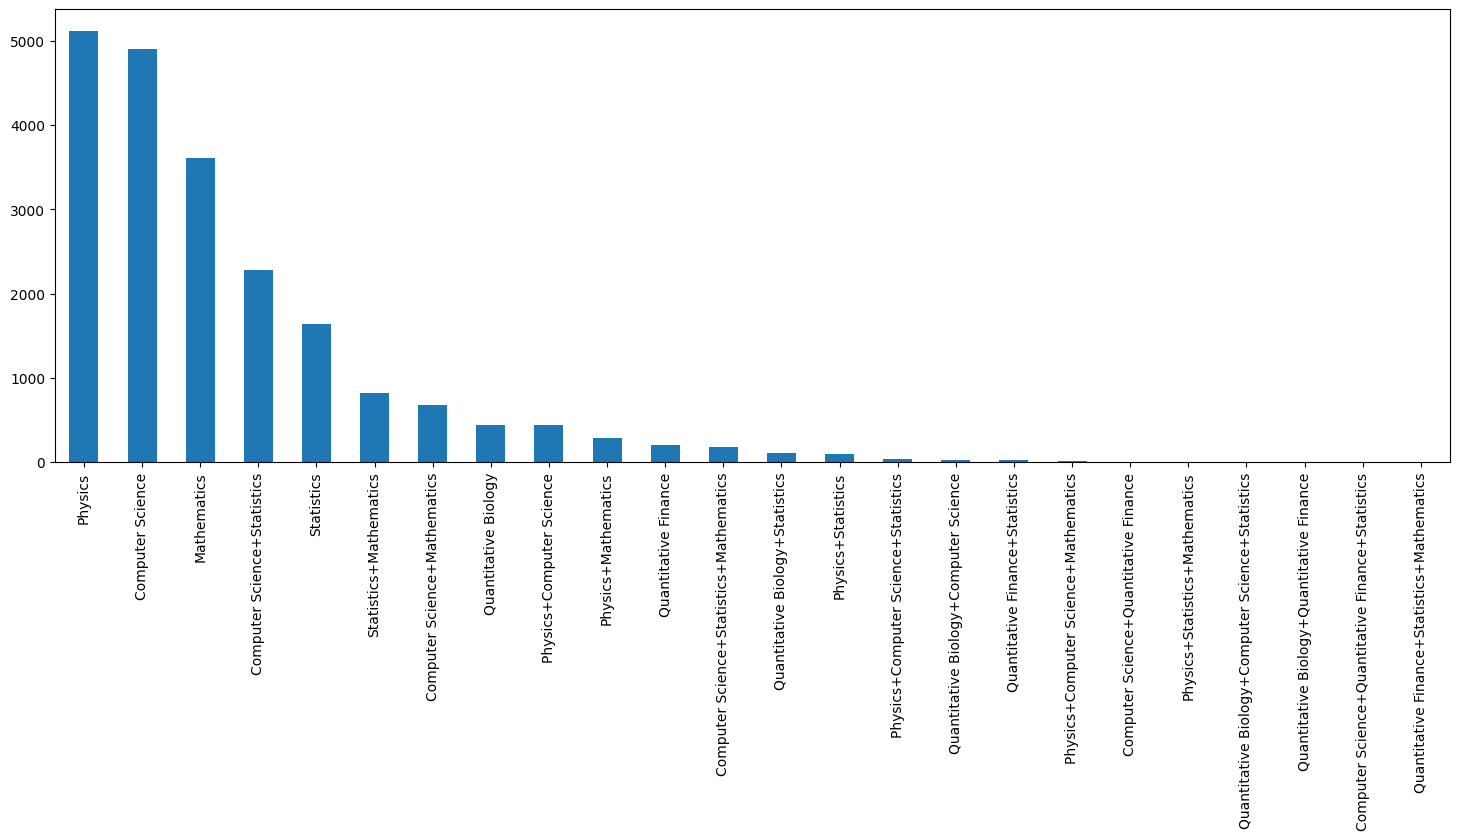

In [ ]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(18, 6), dpi=100, facecolor='w', edgecolor='k')
train['target'].value_counts().plot(kind='bar')

In [ ]:
train.ABSTRACT[0]

"  Predictive models allow subject-specific inference when analyzing disease\nrelated alterations in neuroimaging data. Given a subject's data, inference can\nbe made at two levels: global, i.e. identifiying condition presence for the\nsubject, and local, i.e. detecting condition effect on each individual\nmeasurement extracted from the subject's data. While global inference is widely\nused, local inference, which can be used to form subject-specific effect maps,\nis rarely used because existing models often yield noisy detections composed of\ndispersed isolated islands. In this article, we propose a reconstruction\nmethod, named RSM, to improve subject-specific detections of predictive\nmodeling approaches and in particular, binary classifiers. RSM specifically\naims to reduce noise due to sampling error associated with using a finite\nsample of examples to train classifiers. The proposed method is a wrapper-type\nalgorithm that can be used with different binary classifiers in a diagn

In [ ]:
train.ABSTRACT[1]

'  Rotation invariance and translation invariance have great values in image\nrecognition tasks. In this paper, we bring a new architecture in convolutional\nneural network (CNN) named cyclic convolutional layer to achieve rotation\ninvariance in 2-D symbol recognition. We can also get the position and\norientation of the 2-D symbol by the network to achieve detection purpose for\nmultiple non-overlap target. Last but not least, this architecture can achieve\none-shot learning in some cases using those invariance.\n'

In [ ]:
train.TITLE[3]

'A finite element approximation for the stochastic Maxwell--Landau--Lifshitz--Gilbert system'

In [ ]:
train['target'].value_counts()

Physics                                             5120
Computer Science                                    4910
Mathematics                                         3610
Computer Science+Statistics                         2285
Statistics                                          1636
Statistics+Mathematics                               825
Computer Science+Mathematics                         682
Quantitative Biology                                 443
Physics+Computer Science                             437
Physics+Mathematics                                  293
Quantitative Finance                                 209
Computer Science+Statistics+Mathematics              179
Quantitative Biology+Statistics                      105
Physics+Statistics                                    99
Physics+Computer Science+Statistics                   36
Quantitative Biology+Computer Science                 30
Quantitative Finance+Statistics                       24
Physics+Computer Science+Mathem

In [ ]:
train['target'] = np.where(train['target'] == 'Quantitative Finance+Statistics+Mathematics', 'Statistics+Mathematics', 
                      np.where(train['target']  == 'Computer Science+Quantitative Finance+Statistics',
                               'Computer Science+Statistics', train['target']))

train['target'] = np.where(train['target'] == 'Quantitative Biology+Quantitative Finance', 'Quantitative Finance', 
                      np.where(train['target']  == 'Quantitative Biology+Computer Science+Statistics',
                               'Computer Science+Statistics', train['target']))

train['target'] = np.where(train['target'] == 'Computer Science+Quantitative Finance', 'Quantitative Finance', 
                      np.where(train['target']  == 'Mathematics+Physics+Statistics',
                               'Statistics+Physics', train['target']))


train['target'] = np.where(train['target'] == 'Physics+Computer Science+Mathematics', 'Computer Science+Statistics', 
                      np.where(train['target']  == 'Quantitative Finance+Statistics',
                               'Quantitative Finance', train['target']))

train['target'] = np.where(train['target'] == 'Quantitative Biology+Computer Science', 'Quantitative Biology', 
                      np.where(train['target']  == 'Physics+Statistics+Mathematics',
                               'Computer Science+Statistics', train['target']))

train['target'] = np.where(train['target'] == 'Physics+Statistics', 'Physics', 
                      np.where(train['target']  == 'Quantitative Biology+Statistics',
                               'Quantitative Biology', train['target']))


train['target'] = np.where(train['target'] == 'Mathematics+Statistics', 'Statistics+Mathematics', train['target'])



In [ ]:
train.target.value_counts()

Physics                                    5219
Computer Science                           4910
Mathematics                                3610
Computer Science+Statistics                2356
Statistics                                 1636
Statistics+Mathematics                      826
Computer Science+Mathematics                682
Quantitative Biology                        578
Physics+Computer Science                    437
Physics+Mathematics                         293
Quantitative Finance                        246
Computer Science+Statistics+Mathematics     179
Name: target, dtype: int64

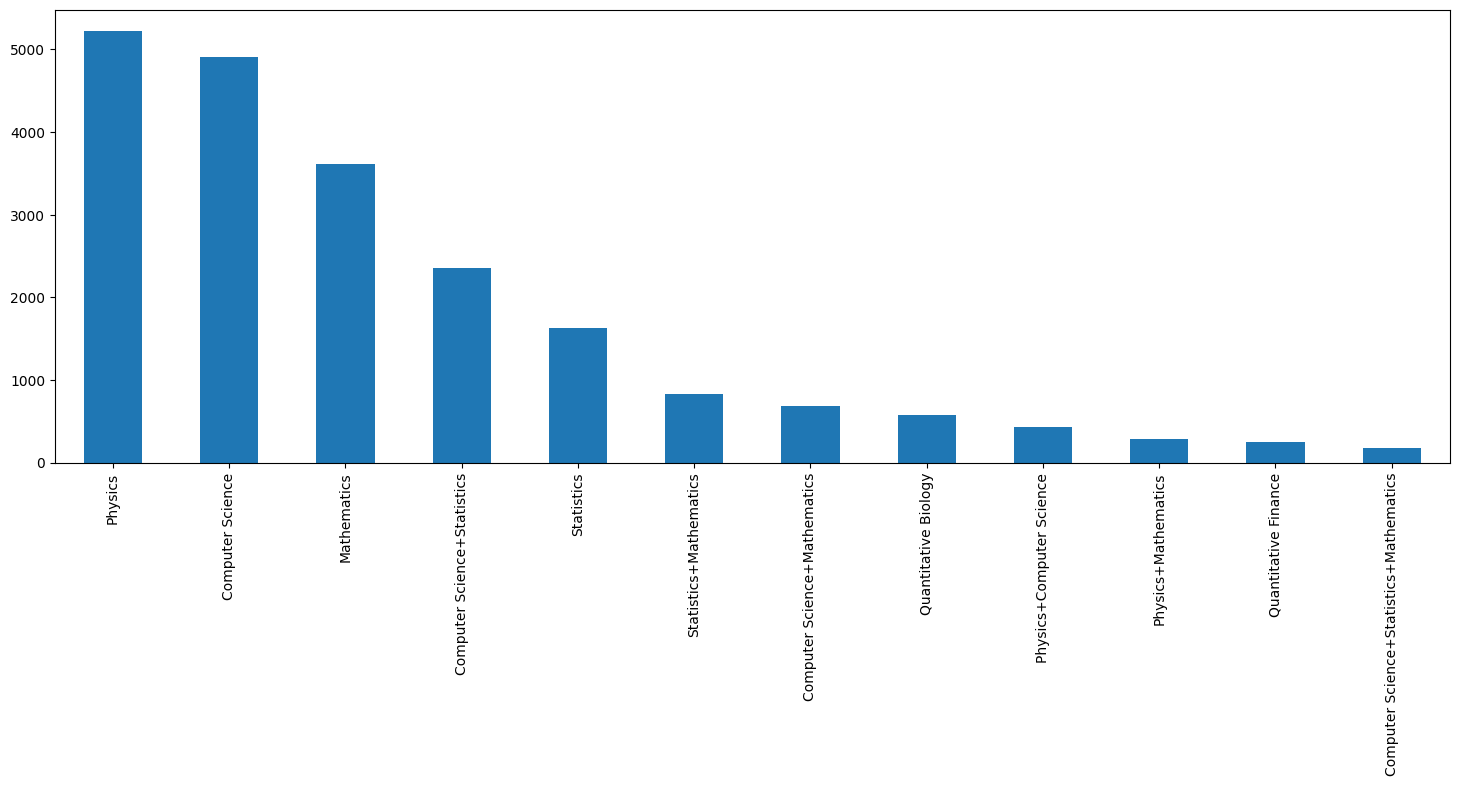

In [ ]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(18, 6), dpi=100, facecolor='w', edgecolor='k')
train.target.value_counts().plot(kind='bar')

In [ ]:
train['text'] = train[['TITLE', 'ABSTRACT']].apply(lambda x: ' '.join(x), axis=1)
test['text'] = test[['TITLE', 'ABSTRACT']].apply(lambda x: ' '.join(x), axis=1)
train

,ID,target,text
0,1,Computer Science,Reconstructing Subject-Specific Effect Maps ...
1,2,Computer Science,Rotation Invariance Neural Network Rotation ...
2,3,Mathematics,Spherical polyharmonics and Poisson kernels fo...
3,4,Mathematics,A finite element approximation for the stochas...
4,5,Computer Science+Statistics,Comparative study of Discrete Wavelet Transfor...
...,...,...,...
20967,20968,Physics+Computer Science,Contemporary machine learning: a guide for pra...
20968,20969,Physics,Uniform diamond coatings on WC-Co hard alloy c...
20969,20970,Computer Science,Analysing Soccer Games with Clustering and Con...
20970,20971,Statistics+Mathematics,On the Efficient Simulation of the Left-Tail o...


In [ ]:
train.text[0]

"Reconstructing Subject-Specific Effect Maps   Predictive models allow subject-specific inference when analyzing disease\nrelated alterations in neuroimaging data. Given a subject's data, inference can\nbe made at two levels: global, i.e. identifiying condition presence for the\nsubject, and local, i.e. detecting condition effect on each individual\nmeasurement extracted from the subject's data. While global inference is widely\nused, local inference, which can be used to form subject-specific effect maps,\nis rarely used because existing models often yield noisy detections composed of\ndispersed isolated islands. In this article, we propose a reconstruction\nmethod, named RSM, to improve subject-specific detections of predictive\nmodeling approaches and in particular, binary classifiers. RSM specifically\naims to reduce noise due to sampling error associated with using a finite\nsample of examples to train classifiers. The proposed method is a wrapper-type\nalgorithm that can be used 

In [ ]:
ref_cat = train[['TITLE','ABSTRACT']]
train.drop(ref_cat,axis=1,inplace=True)
ref_cat = test[['TITLE','ABSTRACT']]
test.drop(ref_cat,axis=1,inplace=True)

In [ ]:
train.head()

,ID,target,text
0,1,Computer Science,Reconstructing Subject-Specific Effect Maps ...
1,2,Computer Science,Rotation Invariance Neural Network Rotation ...
2,3,Mathematics,Spherical polyharmonics and Poisson kernels fo...
3,4,Mathematics,A finite element approximation for the stochas...
4,5,Computer Science+Statistics,Comparative study of Discrete Wavelet Transfor...


In [ ]:
df = train.copy()
lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

df["text_lemmatized"] = df["text"].apply(lambda text: lemmatize_words(text))
test["text_lemmatized"] = test["text"].apply(lambda text: lemmatize_words(text))
df.head()

In [ ]:
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

df["text_lemmatized"] = df["text"].apply(lambda text: lemmatize_words(text))
test["text_lemmatized"] = test["text"].apply(lambda text: lemmatize_words(text))
df.head()

,ID,target,text,text_lemmatized,text_lower,text_wo_stopfreq,text_wo_stopfreqrare,length
0,1,Computer Science,Reconstructing Subject-Specific Effect Maps ...,Reconstructing Effect Maps Predictive model al...,reconstructing effect maps predictive model al...,reconstructing effect maps predictive allow in...,reconstructing effect maps predictive allow in...,974
1,2,Computer Science,Rotation Invariance Neural Network Rotation ...,Rotation Invariance Neural Network Rotation in...,rotation invariance neural network rotation in...,rotation invariance neural rotation invariance...,rotation invariance neural rotation invariance...,277
2,3,Mathematics,Spherical polyharmonics and Poisson kernels fo...,Spherical kernel function introduce develop no...,spherical kernel function introduce develop no...,spherical kernel introduce develop notion sphe...,spherical kernel introduce develop notion sphe...,271
3,4,Mathematics,A finite element approximation for the stochas...,A finite element approximation stochastic syst...,a finite element approximation stochastic syst...,finite element approximation stochastic stocha...,finite element approximation stochastic stocha...,418
4,5,Computer Science+Statistics,Comparative study of Discrete Wavelet Transfor...,Comparative study Discrete Wavelet Transforms ...,comparative study discrete wavelet transforms ...,comparative discrete wavelet transforms wavele...,comparative discrete wavelet transforms wavele...,625


In [ ]:
def check_for_word(s):
    return ' '.join(w for w in str(s).split(' ') if len(wordnet.synsets(w)) > 0)

tqdm.pandas(desc="Checking for Words in Keywords")
df['text_lemmatized'] = df['text_lemmatized'].progress_apply(check_for_word)
test["text_lemmatized"] = test["text"].progress_apply(check_for_word)





Checking for Words in Keywords:   0%|          | 0/8989 [00:00<?, ?it/s]



Checking for Words in Keywords:   0%|          | 33/8989 [00:00<00:27, 326.27it/s]



Checking for Words in Keywords:   1%|          | 73/8989 [00:00<00:25, 343.64it/s]



Checking for Words in Keywords:   1%|▏         | 116/8989 [00:00<00:24, 364.51it/s]



Checking for Words in Keywords:   2%|▏         | 156/8989 [00:00<00:23, 372.58it/s]



Checking for Words in Keywords:   2%|▏         | 198/8989 [00:00<00:22, 384.25it/s]



Checking for Words in Keywords:   3%|▎         | 248/8989 [00:00<00:21, 412.72it/s]



Checking for Words in Keywords:   3%|▎         | 294/8989 [00:00<00:20, 424.08it/s]



Checking for Words in Keywords:   4%|▍         | 338/8989 [00:00<00:20, 427.49it/s]



Checking for Words in Keywords:   4%|▍         | 380/8989 [00:00<00:20, 423.49it/s]



Checking for Words in Keywords:   5%|▍         | 430/8989 [00:01<00:19, 442.39it/s]



Checking for Words in Keywords:   5%|▌         | 477

In [ ]:
df["text_lower"] = df["text_lemmatized"].str.lower()

test["text_lower"] = test["text_lemmatized"].str.lower()

df.head()

In [ ]:
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

df["text_wo_punct"] = df["text_lower"].apply(lambda text: remove_punctuation(text))

test["text_wo_punct"] = test["text_lower"].apply(lambda text: remove_punctuation(text))
df.head()

In [ ]:
df.text_wo_punct[14]

'direct evidence spontaneous vortex state in ferromagnetic using magnetic force microscopy provide direct experimental evidence spontaneous vortex phase formation in single crystal ferromagnetic transition spontaneous pair are imaged in vicinity cooling cycle near observe transition short period domain appears in meissner long period domain structure spontaneous it is first experimental observation scenario in ferromagnetic phase is characterized by much larger domain in state peculiar branched striped structure at are typical perpendicular magnetic anisotropy domain wall parameter at various temperature are'

In [ ]:
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [ ]:
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df["text_wo_stop"] = df["text_wo_punct"].apply(lambda text: remove_stopwords(text))

test["text_wo_stop"] = test["text_wo_punct"].apply(lambda text: remove_stopwords(text))
df.head()

,ID,target,text,text_lemmatized,text_lower,text_wo_stopfreq,text_wo_stopfreqrare,length
0,1,Computer Science,Reconstructing Subject-Specific Effect Maps ...,Reconstructing Effect Maps Predictive model al...,reconstructing effect maps predictive model al...,reconstructing effect maps predictive allow in...,reconstructing effect maps predictive allow in...,974
1,2,Computer Science,Rotation Invariance Neural Network Rotation ...,Rotation Invariance Neural Network Rotation in...,rotation invariance neural network rotation in...,rotation invariance neural rotation invariance...,rotation invariance neural rotation invariance...,277
2,3,Mathematics,Spherical polyharmonics and Poisson kernels fo...,Spherical kernel function introduce develop no...,spherical kernel function introduce develop no...,spherical kernel introduce develop notion sphe...,spherical kernel introduce develop notion sphe...,271
3,4,Mathematics,A finite element approximation for the stochas...,A finite element approximation stochastic syst...,a finite element approximation stochastic syst...,finite element approximation stochastic stocha...,finite element approximation stochastic stocha...,418
4,5,Computer Science+Statistics,Comparative study of Discrete Wavelet Transfor...,Comparative study Discrete Wavelet Transforms ...,comparative study discrete wavelet transforms ...,comparative discrete wavelet transforms wavele...,comparative discrete wavelet transforms wavele...,625


In [ ]:
cnt = Counter()
for text in df["text_wo_stop"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(25)

[('model', 13237),
 ('method', 9179),
 ('show', 8756),
 ('data', 8735),
 ('using', 8566),
 ('result', 8252),
 ('network', 7652),
 ('system', 6729),
 ('algorithm', 6710),
 ('learning', 6677),
 ('problem', 6656),
 ('also', 6429),
 ('approach', 6139),
 ('based', 6052),
 ('ha', 5876),
 ('two', 5866),
 ('study', 5546),
 ('new', 5333),
 ('number', 4650),
 ('function', 4638),
 ('time', 4612),
 ('present', 4524),
 ('different', 4457),
 ('one', 4418),
 ('proposed', 4413)]

In [ ]:
FREQWORDS = set([w for (w, wc) in cnt.most_common(25)])
def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

df["text_wo_stopfreq"] = df["text_wo_stop"].apply(lambda text: remove_freqwords(text))

test["text_wo_stopfreq"] = test["text_wo_stop"].apply(lambda text: remove_freqwords(text))
df.head()

,ID,target,text,text_lemmatized,text_lower,text_wo_stopfreq,text_wo_stopfreqrare,length
0,1,Computer Science,Reconstructing Subject-Specific Effect Maps ...,Reconstructing Effect Maps Predictive model al...,reconstructing effect maps predictive model al...,reconstructing effect maps predictive allow in...,reconstructing effect maps predictive allow in...,974
1,2,Computer Science,Rotation Invariance Neural Network Rotation ...,Rotation Invariance Neural Network Rotation in...,rotation invariance neural network rotation in...,rotation invariance neural rotation invariance...,rotation invariance neural rotation invariance...,277
2,3,Mathematics,Spherical polyharmonics and Poisson kernels fo...,Spherical kernel function introduce develop no...,spherical kernel function introduce develop no...,spherical kernel introduce develop notion sphe...,spherical kernel introduce develop notion sphe...,271
3,4,Mathematics,A finite element approximation for the stochas...,A finite element approximation stochastic syst...,a finite element approximation stochastic syst...,finite element approximation stochastic stocha...,finite element approximation stochastic stocha...,418
4,5,Computer Science+Statistics,Comparative study of Discrete Wavelet Transfor...,Comparative study Discrete Wavelet Transforms ...,comparative study discrete wavelet transforms ...,comparative discrete wavelet transforms wavele...,comparative discrete wavelet transforms wavele...,625


##Removal of Rare words¶
This is very similar to previous preprocessing step but we will remove the rare words from the corpus.

In [ ]:
# Drop the two columns which are no more needed 
df.drop(["text_wo_punct", "text_wo_stop"], axis=1, inplace=True)

n_rare_words = 10
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
def remove_rarewords(text):
    """custom function to remove the rare words"""
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])

df["text_wo_stopfreqrare"] = df["text_wo_stopfreq"].apply(lambda text: remove_rarewords(text))

test["text_wo_stopfreqrare"] = test["text_wo_stopfreq"].apply(lambda text: remove_rarewords(text))
df.head()

,ID,target,text,text_lemmatized,text_lower,text_wo_stopfreq,text_wo_stopfreqrare,length
0,1,Computer Science,Reconstructing Subject-Specific Effect Maps ...,Reconstructing Effect Maps Predictive model al...,reconstructing effect maps predictive model al...,reconstructing effect maps predictive allow in...,reconstructing effect maps predictive allow in...,974
1,2,Computer Science,Rotation Invariance Neural Network Rotation ...,Rotation Invariance Neural Network Rotation in...,rotation invariance neural network rotation in...,rotation invariance neural rotation invariance...,rotation invariance neural rotation invariance...,277
2,3,Mathematics,Spherical polyharmonics and Poisson kernels fo...,Spherical kernel function introduce develop no...,spherical kernel function introduce develop no...,spherical kernel introduce develop notion sphe...,spherical kernel introduce develop notion sphe...,271
3,4,Mathematics,A finite element approximation for the stochas...,A finite element approximation stochastic syst...,a finite element approximation stochastic syst...,finite element approximation stochastic stocha...,finite element approximation stochastic stocha...,418
4,5,Computer Science+Statistics,Comparative study of Discrete Wavelet Transfor...,Comparative study Discrete Wavelet Transforms ...,comparative study discrete wavelet transforms ...,comparative discrete wavelet transforms wavele...,comparative discrete wavelet transforms wavele...,625


In [ ]:
print('Number of sentences in training set:',len(df['text_wo_stopfreqrare'].unique()))
# print('Number of sentences in test set:',len(test['user_review'].unique()))

Number of sentences in training set: 20972


In [ ]:
def length(text):    
    '''a function which returns the length of text'''
    return len(text)
df['length'] = df['text_wo_stopfreqrare'].apply(length)
df


,ID,target,text,text_lemmatized,text_lower,text_wo_stopfreq,text_wo_stopfreqrare,length
0,1,Computer Science,Reconstructing Subject-Specific Effect Maps ...,Reconstructing Effect Maps Predictive model al...,reconstructing effect maps predictive model al...,reconstructing effect maps predictive allow in...,reconstructing effect maps predictive allow in...,974
1,2,Computer Science,Rotation Invariance Neural Network Rotation ...,Rotation Invariance Neural Network Rotation in...,rotation invariance neural network rotation in...,rotation invariance neural rotation invariance...,rotation invariance neural rotation invariance...,277
2,3,Mathematics,Spherical polyharmonics and Poisson kernels fo...,Spherical kernel function introduce develop no...,spherical kernel function introduce develop no...,spherical kernel introduce develop notion sphe...,spherical kernel introduce develop notion sphe...,271
3,4,Mathematics,A finite element approximation for the stochas...,A finite element approximation stochastic syst...,a finite element approximation stochastic syst...,finite element approximation stochastic stocha...,finite element approximation stochastic stocha...,418
4,5,Computer Science+Statistics,Comparative study of Discrete Wavelet Transfor...,Comparative study Discrete Wavelet Transforms ...,comparative study discrete wavelet transforms ...,comparative discrete wavelet transforms wavele...,comparative discrete wavelet transforms wavele...,625
...,...,...,...,...,...,...,...,...
20967,20968,Physics+Computer Science,Contemporary machine learning: a guide for pra...,Contemporary machine a guide practitioner in p...,contemporary machine a guide practitioner in p...,contemporary machine guide practitioner physic...,contemporary machine guide practitioner physic...,808
20968,20969,Physics,Uniform diamond coatings on WC-Co hard alloy c...,Uniform diamond coating on hard alloy cutting ...,uniform diamond coating on hard alloy cutting ...,uniform diamond coating hard alloy cutting ins...,uniform diamond coating hard alloy cutting ins...,573
20969,20970,Computer Science,Analysing Soccer Games with Clustering and Con...,Analysing Soccer Games Clustering present a ne...,analysing soccer games clustering present a ne...,analysing soccer games clustering identifying ...,analysing soccer games clustering identifying ...,622
20970,20971,Statistics+Mathematics,On the Efficient Simulation of the Left-Tail o...,On Efficient Simulation Sum Correlated Variate...,on efficient simulation sum correlated variate...,efficient simulation sum correlated variates s...,efficient simulation sum correlated variates s...,727


Text(0, 0.5, 'Count')

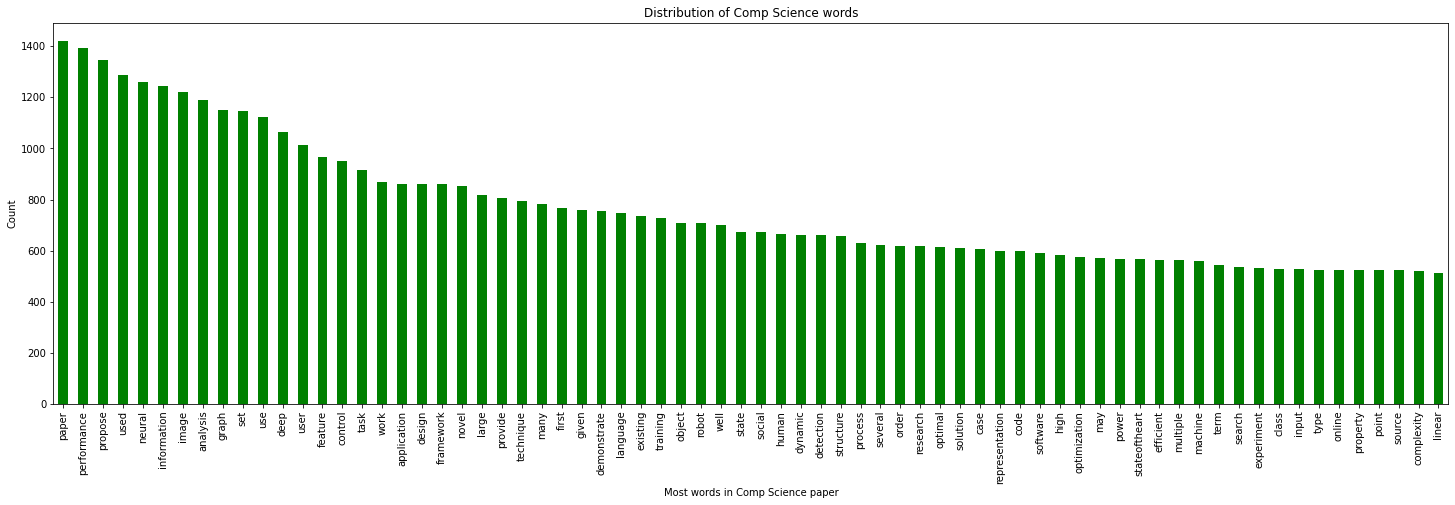

In [ ]:
comp_sci_word=df[df['target']=='Computer Science']['text_wo_stopfreqrare'].str.split(expand=True).stack().value_counts()
plt.figure(figsize=(25,7))
comp_sci_word[:70].plot(kind='bar',color='green')
plt.title("Distribution of Comp Science words")
plt.xlabel('Most words in Comp Science paper')
plt.ylabel('Count')

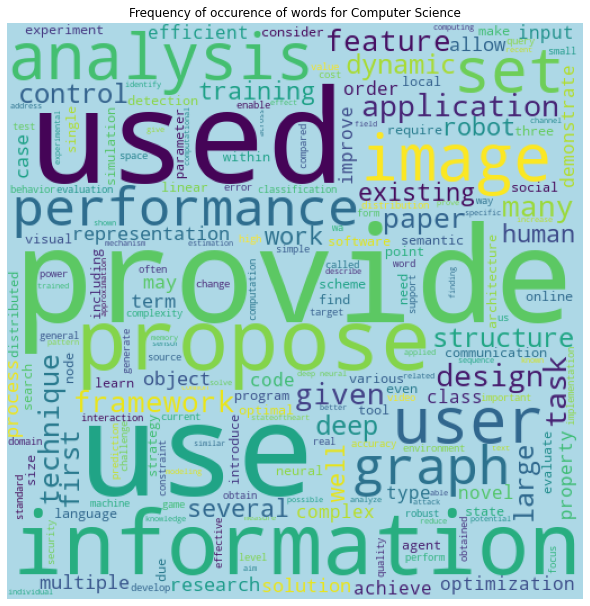

In [ ]:
from wordcloud import WordCloud
comp_sci = ' '.join(list(df[df['target'] == 'Computer Science']['text_wo_stopfreqrare']))
comp_sci_lit = WordCloud(width = 512,height = 512,background_color="lightblue").generate(comp_sci)
plt.figure(figsize = (10, 8),facecolor = 'w')
plt.imshow(comp_sci_lit)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.title("Frequency of occurence of words for Computer Science")
plt.show()

Text(0, 0.5, 'Count')

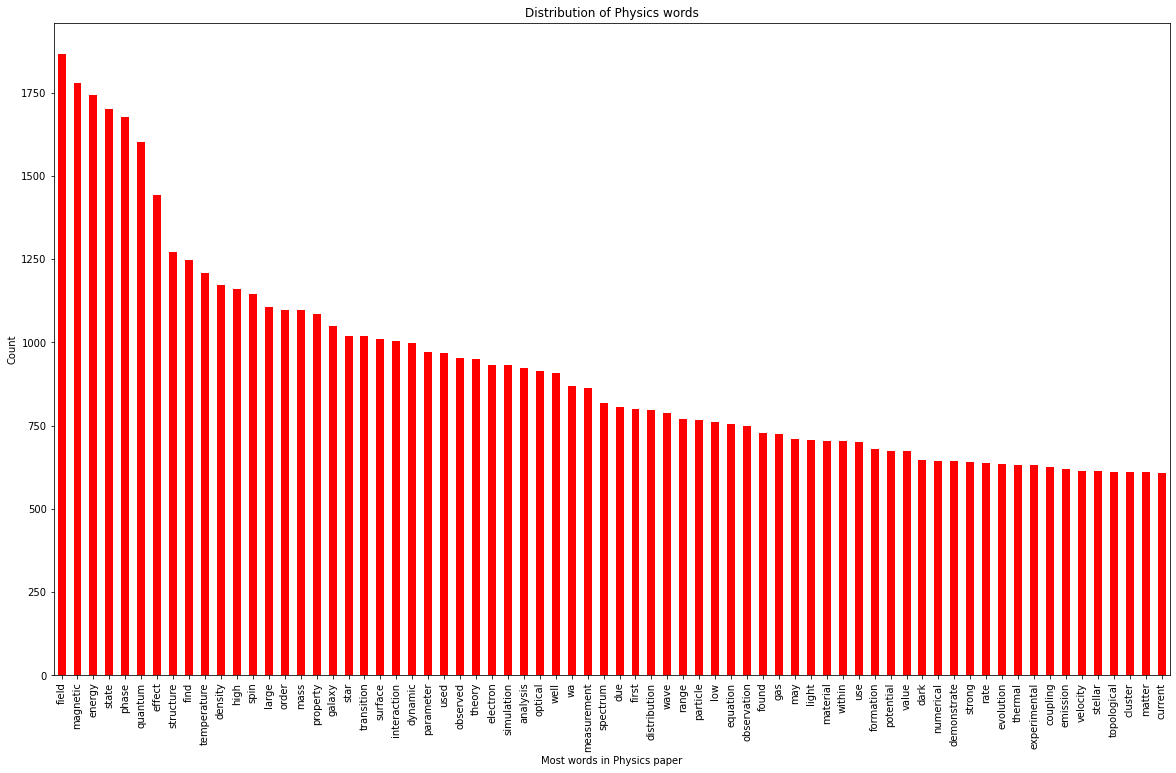

In [ ]:
physics_word=df[df['target']=='Physics']['text_wo_stopfreqrare'].str.split(expand=True).stack().value_counts()
plt.figure(figsize=(20,12))
physics_word[:70].plot(kind='bar',color='red')
plt.title("Distribution of Physics words")
plt.xlabel('Most words in Physics paper')
plt.ylabel('Count')

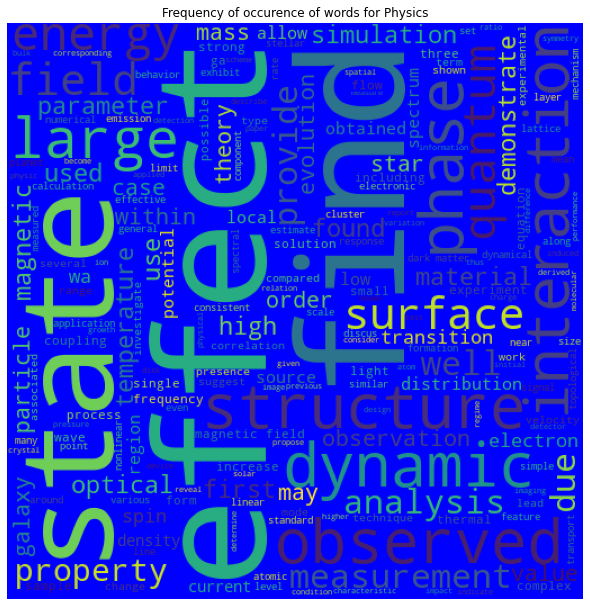

In [ ]:
Physics = ' '.join(list(df[df['target'] == 'Physics']['text_wo_stopfreqrare']))
physics_lit = WordCloud(width = 512,height = 512,background_color="blue").generate(Physics)
plt.figure(figsize = (10, 8),facecolor = 'w')
plt.imshow(physics_lit)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.title("Frequency of occurence of words for Physics")
plt.show()

Text(0, 0.5, 'Count')

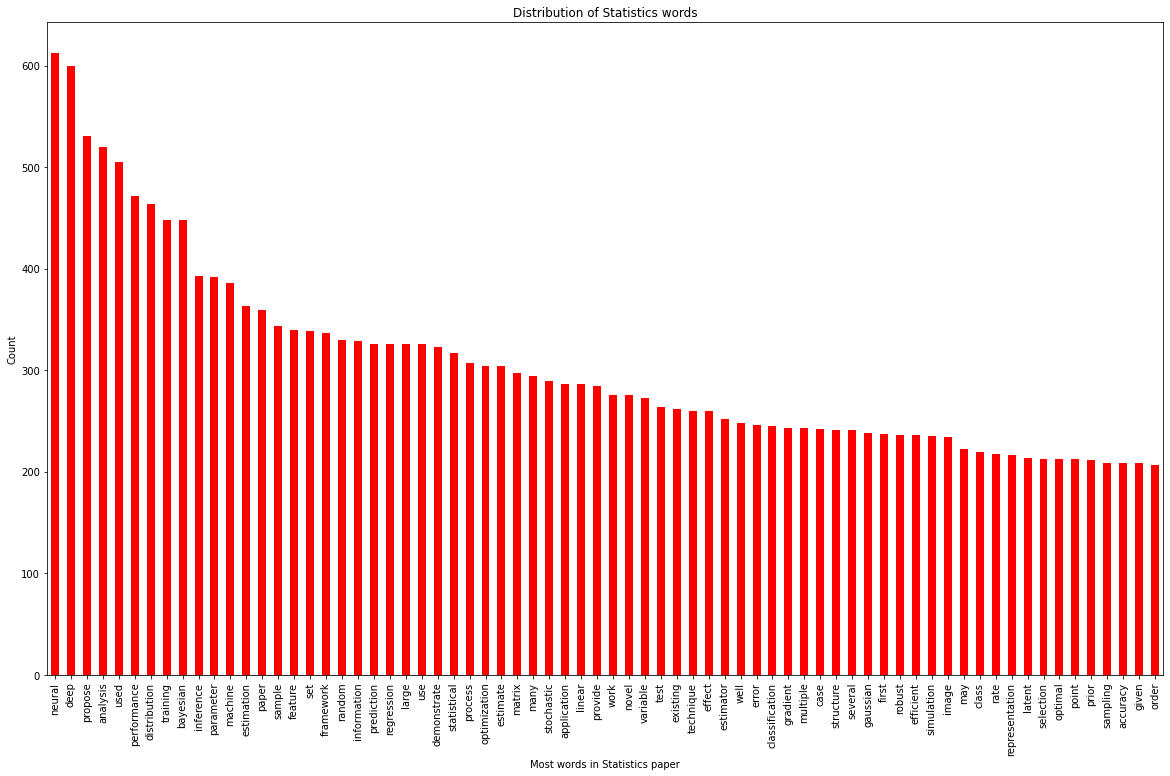

In [ ]:
Statistics_word=df[df['target']=='Statistics']['text_wo_stopfreqrare'].str.split(expand=True).stack().value_counts()
plt.figure(figsize=(20,12))
Statistics_word[:70].plot(kind='bar',color='red')
plt.title("Distribution of Statistics words")
plt.xlabel('Most words in Statistics paper')
plt.ylabel('Count')

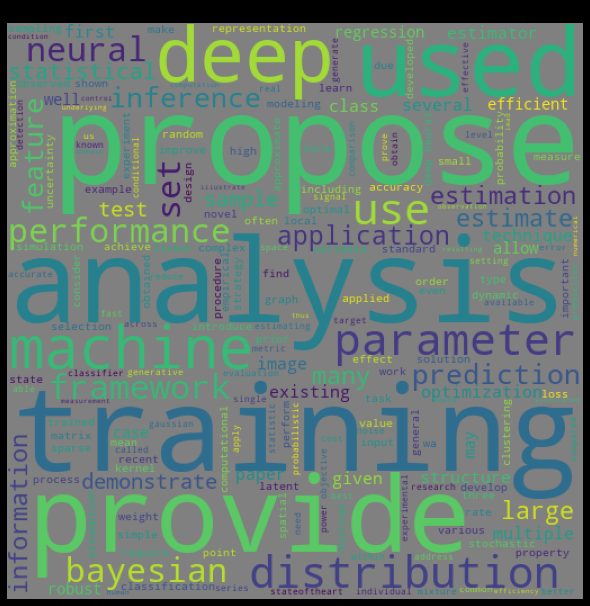

In [ ]:
Statistics = ' '.join(list(df[df['target'] == 'Statistics']['text_wo_stopfreqrare']))
Statistics_lit = WordCloud(width = 512,height = 512,background_color="gray").generate(Statistics)
plt.figure(figsize = (10, 8),facecolor = 'k')
plt.imshow(Statistics_lit)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.title("Frequency of occurence of words for Statistics")
plt.show()

Text(0, 0.5, 'Count')

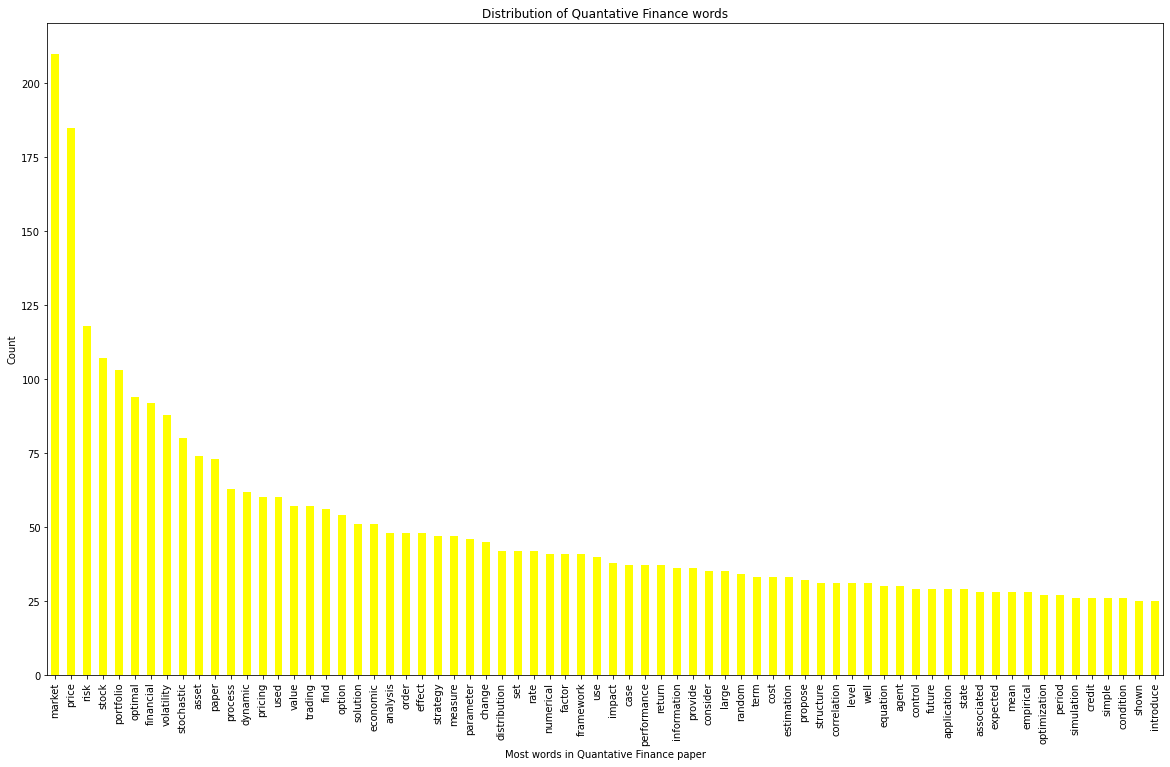

In [ ]:
Quan_fin_word=df[df['target']=='Quantitative Finance']['text_wo_stopfreqrare'].str.split(expand=True).stack().value_counts()
plt.figure(figsize=(20,12))
Quan_fin_word[:70].plot(kind='bar',color='yellow')
plt.title("Distribution of Quantative Finance words")
plt.xlabel('Most words in Quantative Finance paper')
plt.ylabel('Count')

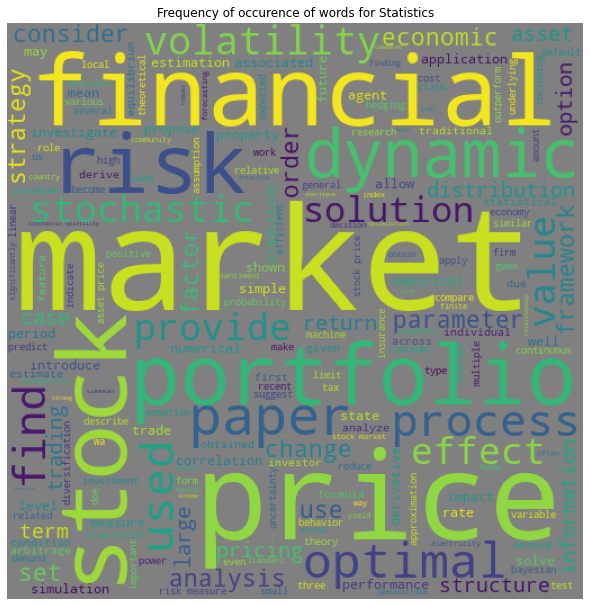

In [ ]:
Finance = ' '.join(list(df[df['target'] == 'Quantitative Finance']['text_wo_stopfreqrare']))
Finance_lit = WordCloud(width = 512,height = 512,background_color="gray").generate(Finance)
plt.figure(figsize = (10, 8),facecolor = 'w')
plt.imshow(Finance_lit)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.title("Frequency of occurence of words for Statistics")
plt.show()

Text(0, 0.5, 'Count')

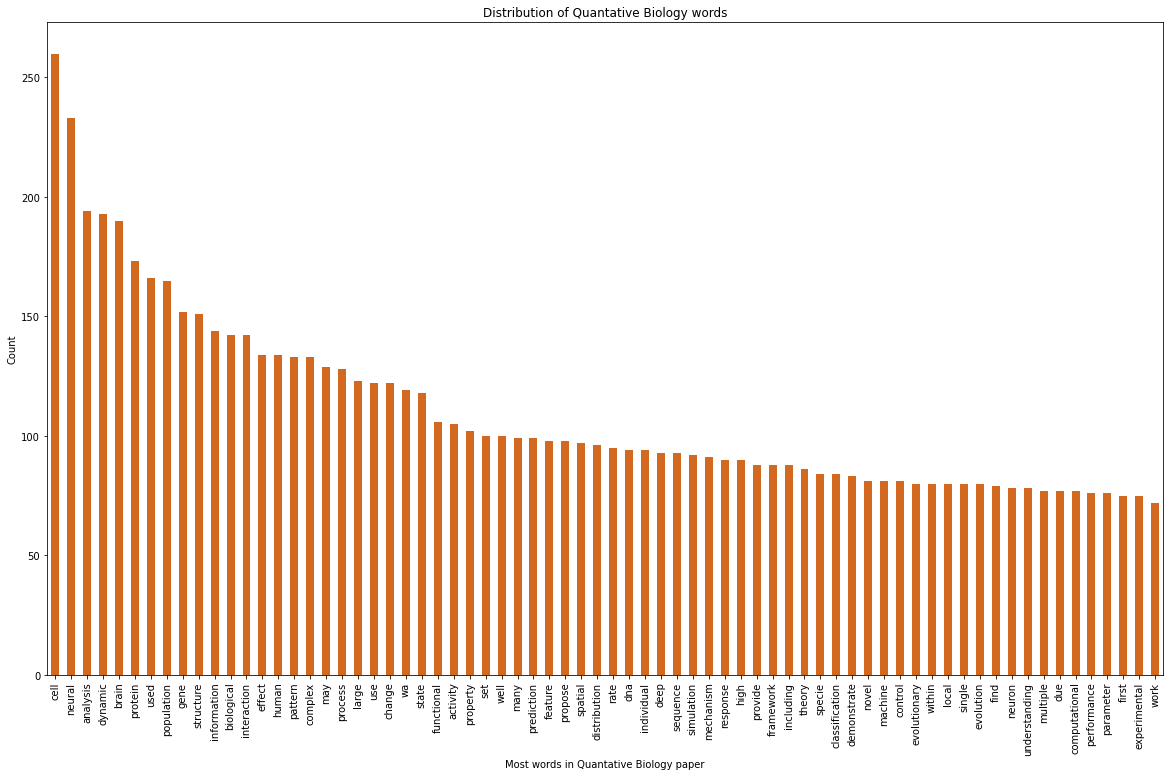

In [ ]:
Quan_bio_word=df[df['target']=='Quantitative Biology']['text_wo_stopfreqrare'].str.split(expand=True).stack().value_counts()
plt.figure(figsize=(20,12))
Quan_bio_word[:70].plot(kind='bar',color='chocolate')
plt.title("Distribution of Quantative Biology words")
plt.xlabel('Most words in Quantative Biology paper')
plt.ylabel('Count')

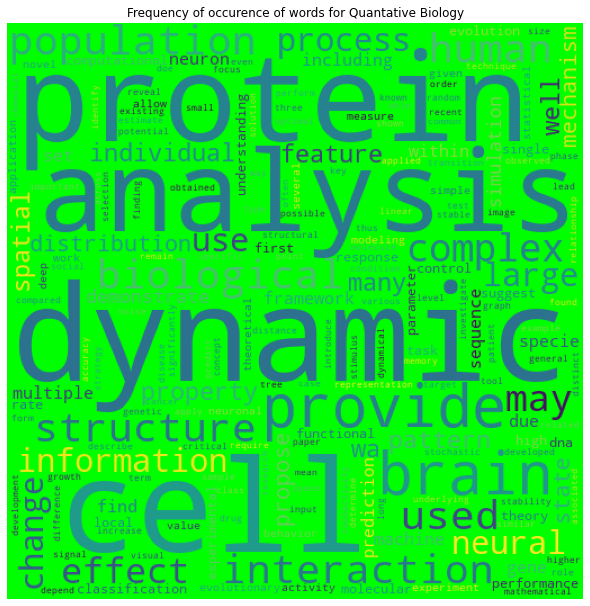

In [ ]:
Biology = ' '.join(list(df[df['target'] == 'Quantitative Biology']['text_wo_stopfreqrare']))
Quan_Bio_lit = WordCloud(width = 512,height = 512,background_color="lime").generate(Biology)
plt.figure(figsize = (10, 8),facecolor = 'w')
plt.imshow(Quan_Bio_lit)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.title("Frequency of occurence of words for Quantative Biology")
plt.show()

In [ ]:
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(df.target.values)

In [ ]:
df.target.value_counts()


Physics                                    5219
Computer Science                           4910
Mathematics                                3610
Computer Science+Statistics                2356
Statistics                                 1636
Statistics+Mathematics                      826
Computer Science+Mathematics                682
Quantitative Biology                        578
Physics+Computer Science                    437
Physics+Mathematics                         293
Quantitative Finance                        246
Computer Science+Statistics+Mathematics     179
Name: target, dtype: int64

In [ ]:
xtrain, xvalid, ytrain, yvalid = train_test_split(df.text_wo_stopfreqrare.values, y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.3, shuffle=True)

In [ ]:
print (xtrain.shape)
print (xvalid.shape)

(14680,)
(6292,)


In [ ]:
# Always start with these features. They work (almost) everytime!
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(xtrain) + list(xvalid))
xtrain_tfv =  tfv.transform(xtrain) 
xvalid_tfv = tfv.transform(xvalid)
test_tfv = tfv.transform(test.text_wo_stopfreqrare)

In [ ]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

In [ ]:
# Fitting a simple Logistic Regression on TFIDF
clf = LogisticRegression(C=1.0)
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict_proba(xvalid_tfv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 1.035 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfTransformer
from xgboost import XGBClassifier

In [ ]:
ctv = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), stop_words = 'english')

# Fitting Count Vectorizer to both training and test sets (semi-supervised learning)
ctv.fit(list(xtrain) + list(xvalid))
xtrain_ctv =  ctv.transform(xtrain) 
xvalid_ctv = ctv.transform(xvalid)
test_ctv = ctv.transform(test.text_wo_stopfreqrare)
# Fitting a simple Logistic Regression on Counts
clf = LogisticRegression(C=1.0)
clf.fit(xtrain_ctv, ytrain)
predictions = clf.predict_proba(xvalid_ctv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

In [ ]:
ctv = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), stop_words = 'english')

# Fitting Count Vectorizer to both training and test sets (semi-supervised learning)
ctv.fit(list(xtrain) + list(xvalid))
xtrain_ctv =  ctv.transform(xtrain) 
xvalid_ctv = ctv.transform(xvalid)
test_ctv = ctv.transform(test.text_wo_stopfreqrare)

In [ ]:
# Fitting a simple Logistic Regression on Counts
clf = LogisticRegression(C=1.0)
clf.fit(xtrain_ctv, ytrain)
predictions = clf.predict_proba(xvalid_ctv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


logloss: 1.114 


In [ ]:
# Fitting a simple Naive Bayes on TFIDF
clf = MultinomialNB()
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict_proba(xvalid_tfv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 1.653 


In [ ]:
# Fitting a simple Naive Bayes on Counts
clf = MultinomialNB()
clf.fit(xtrain_ctv, ytrain)
predictions = clf.predict_proba(xvalid_ctv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 8.868 


In [ ]:
# Apply SVD, I chose 120 components. 120-200 components are good enough for SVM model.
svd = decomposition.TruncatedSVD(n_components=120)
svd.fit(xtrain_tfv)
xtrain_svd = svd.transform(xtrain_tfv)
xvalid_svd = svd.transform(xvalid_tfv)
test_svd = svd.transform(test_tfv)

# Scale the data obtained from SVD. Renaming variable to reuse without scaling.
scl = preprocessing.StandardScaler()
scl.fit(xtrain_svd)
xtrain_svd_scl = scl.transform(xtrain_svd)
xvalid_svd_scl = scl.transform(xvalid_svd)
test_svd_scl = scl.transform(test_svd)

In [ ]:
# Fitting a simple SVM
clf = SVC(C=1.0, probability=True) # since we need probabilities
clf.fit(xtrain_svd_scl, ytrain)
predictions = clf.predict_proba(xvalid_svd_scl)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.930 


In [ ]:
# Fitting a simple xgboost on tf-idf
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(xtrain_tfv.tocsc(), ytrain)
predictions = clf.predict_proba(xvalid_tfv.tocsc())

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 1.058 


In [ ]:
# Fitting a simple xgboost on tf-idf svd features
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(xtrain_svd, ytrain)
predictions = clf.predict_proba(xvalid_svd)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 1.020 


In [ ]:
# Fitting a simple xgboost on tf-idf svd features
clf = xgb.XGBClassifier(nthread=10)
clf.fit(xtrain_svd, ytrain)
predictions = clf.predict_proba(xvalid_svd)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.971 


In [ ]:
mll_scorer = metrics.make_scorer(multiclass_logloss, greater_is_better=False, needs_proba=True)

In [ ]:
# Initialize SVD
svd = TruncatedSVD()
    
# Initialize the standard scaler 
scl = preprocessing.StandardScaler()

# We will use logistic regression here..
lr_model = LogisticRegression()

# Create the pipeline 
clf = pipeline.Pipeline([('svd', svd),
                         ('scl', scl),
                         ('lr', lr_model)])

In [ ]:
param_grid = {'svd__n_components' : [120, 180],
              'lr__C': [0.1, 1.0, 10], 
              'lr__penalty': ['l1', 'l2']}

In [ ]:
# Initialize Grid Search Model
model = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=mll_scorer,
                                 verbose=10, n_jobs=-1, iid=True, refit=True, cv=2)

# Fit Grid Search Model
model.fit(xtrain_tfv, ytrain)  # we can use the full data here but im only using xtrain
print("Best score: %0.3f" % model.best_score_)
print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 2 folds for each of 12 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   58.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  2.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  2.4min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Best score: -0.951
Best parameters set:
	lr__C: 0.1
	lr__penalty: 'l2'
	svd__n_components: 120


In [ ]:
nb_model = MultinomialNB()

# Create the pipeline 
clf = pipeline.Pipeline([('nb', nb_model)])

# parameter grid
param_grid = {'nb__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

# Initialize Grid Search Model
model = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=mll_scorer,
                                 verbose=10, n_jobs=-1, iid=True, refit=True, cv=2)

# Fit Grid Search Model
model.fit(xtrain_tfv, ytrain)  # we can use the full data here but im only using xtrain. 
print("Best score: %0.3f" % model.best_score_)
print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1697s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s


Best score: -1.090
Best parameters set:
	nb__alpha: 0.01


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.9s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.text_wo_stopfreqrare.values, y, test_size=0.33)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


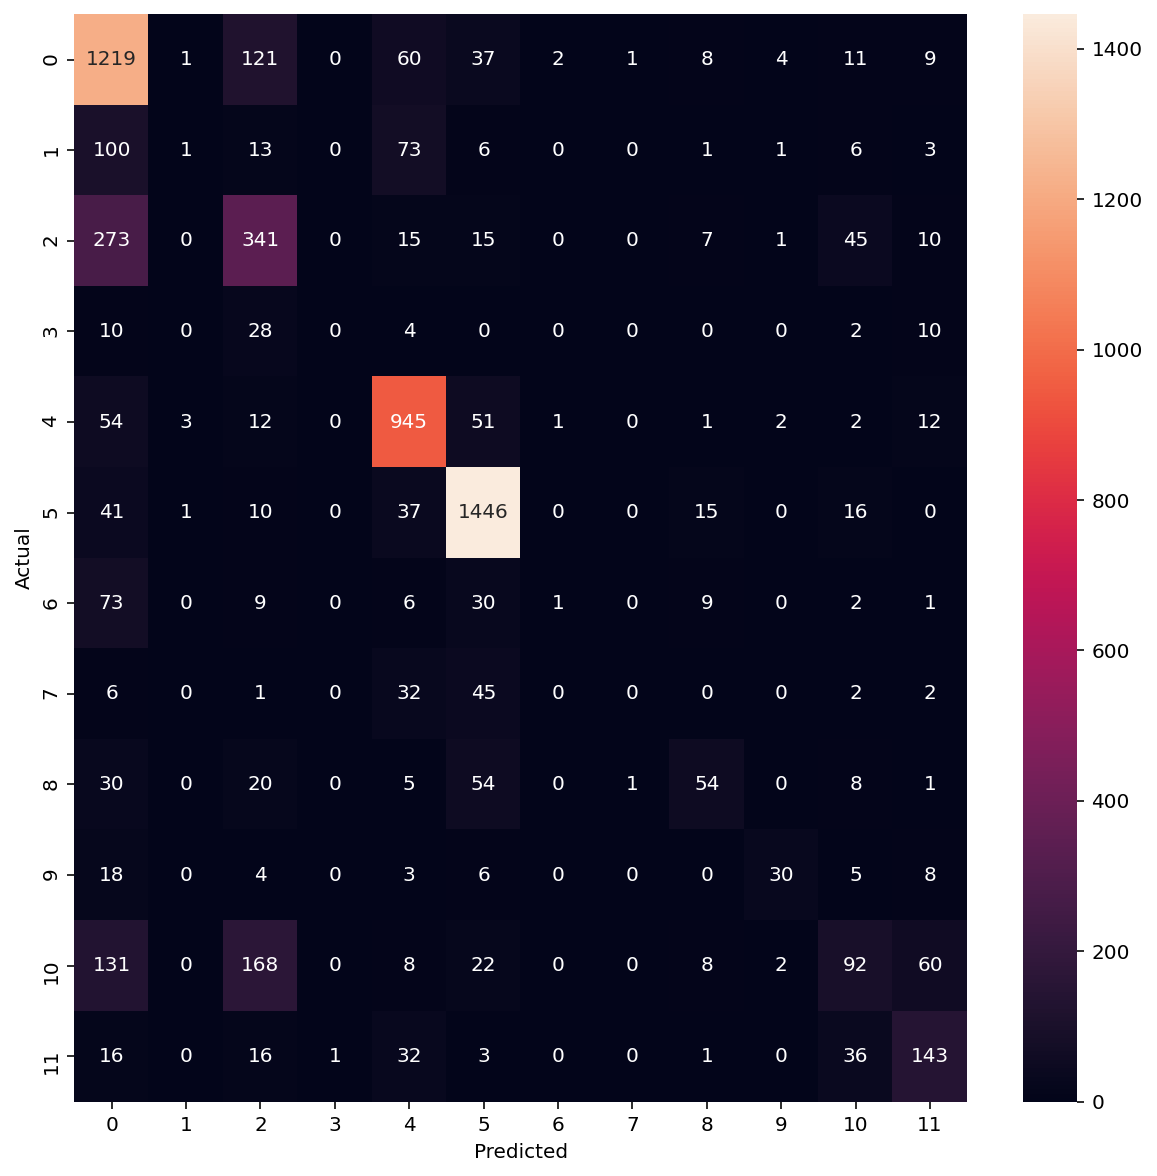

In [ ]:
model = LinearSVC()
model.fit(xtrain_svd_scl, ytrain)
y_pred = model.predict(xvalid_svd_scl)

from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(yvalid, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
import seaborn as sns
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
model.fit(xtrain_svd_scl, ytrain)
y_pred = model.predict(xvalid_svd_scl)

In [ ]:
test_pred = model.predict(test_svd_scl)

In [ ]:
# test_pred = pd.DataFrame(test_pred)
test_pred = lbl_enc.inverse_transform(test_pred)
test_pred

array(['Computer Science+Statistics', 'Physics', 'Computer Science', ...,
       'Computer Science', 'Statistics', 'Computer Science'], dtype=object)

In [ ]:
test_pred  = pd.DataFrame(test_pred,columns=['dept_name'])
test_pred

,dept_name
0,Computer Science+Statistics
1,Physics
2,Computer Science
3,Physics
4,Computer Science
...,...
8984,Computer Science
8985,Mathematics
8986,Computer Science
8987,Statistics


In [ ]:
test = pd.get_dummies(test_pred, columns=['dept_name'])
test

,dept_name_Computer Science,dept_name_Computer Science+Mathematics,dept_name_Computer Science+Statistics,dept_name_Computer Science+Statistics+Mathematics,dept_name_Mathematics,dept_name_Physics,dept_name_Physics+Computer Science,dept_name_Quantitative Biology,dept_name_Quantitative Finance,dept_name_Statistics,dept_name_Statistics+Mathematics
0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
8984,1,0,0,0,0,0,0,0,0,0,0
8985,0,0,0,0,1,0,0,0,0,0,0
8986,1,0,0,0,0,0,0,0,0,0,0
8987,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
test['Comp_sci'] = test['dept_name_Computer Science']+test['dept_name_Computer Science+Statistics']+test['dept_name_Computer Science+Statistics+Mathematics']+test['dept_name_Physics+Computer Science']
test['physics'] = test['dept_name_Physics+Computer Science']+test['dept_name_Physics']
test['maths'] = test['dept_name_Computer Science+Mathematics'] +test['dept_name_Computer Science+Statistics+Mathematics']+test['dept_name_Mathematics']+test['dept_name_Statistics+Mathematics']
test['statistics'] = test['dept_name_Computer Science+Statistics']+test['dept_name_Computer Science+Statistics+Mathematics']+test['dept_name_Statistics']+test['dept_name_Statistics+Mathematics']
test['quant_bio']  = test['dept_name_Quantitative Biology']
test['quant_fin'] = test['dept_name_Quantitative Finance']
test

,dept_name_Computer Science,dept_name_Computer Science+Mathematics,dept_name_Computer Science+Statistics,dept_name_Computer Science+Statistics+Mathematics,dept_name_Mathematics,dept_name_Physics,dept_name_Physics+Computer Science,dept_name_Quantitative Biology,dept_name_Quantitative Finance,dept_name_Statistics,dept_name_Statistics+Mathematics,Comp_sci,physics,maths,statistics,quant_bio,quant_fin
0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8984,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
8985,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
8986,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
8987,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0


In [ ]:
test.columns

Index(['dept_name_Computer Science', 'dept_name_Computer Science+Mathematics',
       'dept_name_Computer Science+Statistics',
       'dept_name_Computer Science+Statistics+Mathematics',
       'dept_name_Mathematics', 'dept_name_Physics',
       'dept_name_Physics+Computer Science', 'dept_name_Quantitative Biology',
       'dept_name_Quantitative Finance', 'dept_name_Statistics',
       'dept_name_Statistics+Mathematics', 'Comp_sci', 'physics', 'maths',
       'statistics', 'quant_bio', 'quant_fin'],
      dtype='object')

In [ ]:
ref_cat = test[['dept_name_Computer Science', 'dept_name_Computer Science+Mathematics',
       'dept_name_Computer Science+Statistics',
       'dept_name_Computer Science+Statistics+Mathematics',
       'dept_name_Mathematics', 'dept_name_Physics',
       'dept_name_Physics+Computer Science', 'dept_name_Quantitative Biology',
       'dept_name_Quantitative Finance', 'dept_name_Statistics',
       'dept_name_Statistics+Mathematics']]
test.drop(ref_cat,axis=1,inplace=True)
test

,Comp_sci,physics,maths,statistics,quant_bio,quant_fin
0,1,0,0,1,0,0
1,0,1,0,0,0,0
2,1,0,0,0,0,0
3,0,1,0,0,0,0
4,1,0,0,0,0,0
...,...,...,...,...,...,...
8984,1,0,0,0,0,0
8985,0,0,1,0,0,0
8986,1,0,0,0,0,0
8987,0,0,0,1,0,0


In [ ]:
test.to_csv('/content/drive/My Drive/NLP/xgbnlp.csv')